**Install deepxde**  
Tensorflow and all other dependencies are already installed in Colab terminals

In [1]:
!pip install deepxde


     |███                             | 10 kB 22.0 MB/s eta 0:00:01
     |█████▉                          | 20 kB 21.5 MB/s eta 0:00:01
     |████████▉                       | 30 kB 10.9 MB/s eta 0:00:01
     |███████████▊                    | 40 kB 8.5 MB/s eta 0:00:01
     |██████████████▊                 | 51 kB 5.5 MB/s eta 0:00:01
     |█████████████████▋              | 61 kB 5.6 MB/s eta 0:00:01
     |████████████████████▋           | 71 kB 5.5 MB/s eta 0:00:01
     |███████████████████████▌        | 81 kB 6.2 MB/s eta 0:00:01
     |██████████████████████████▍     | 92 kB 4.9 MB/s eta 0:00:01
     |█████████████████████████████▍  | 102 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 5.3 MB/s 
     |████████████████████████████████| 100 kB 8.9 MB/s 


**Problem setup**  
  
We are going to solve the non-linear Schrödinger equation given by  
$i h_t + \frac{1}{2} h_{xx} + |h|^2h = 0$  
  
with periodic boundary conditions as  
$x \in [-5,5], \quad t \in [0, \pi/2]$  
$h(t, -5) = h(t,5)$  
$h_x(t, -5) = h_x(t,5)$  
  
and initial condition equal to  
$h(0,x) = 2 sech(x)$



Deepxde only uses real numbers, so we need to explicitly split the real and imaginary parts of the complex PDE.  
  
In place of the single residual  
$f = ih_t + \frac{1}{2} h_{xx} +|h|^2 h$  
  
we get the two (real valued) residuals  
$f_{\mathcal{R}} = u_t + \frac{1}{2} v_{xx} + (u^2 + v^2)v$  
$f_{\mathcal{I}} = v_t - \frac{1}{2} u_{xx} - (u^2 + v^2)u$  
  
where u(x,t) and v(x,t) denote respectively the real and the imaginary part of h.  


In [2]:
import numpy as np

import deepxde as dde

# For plotting
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term



In [3]:
x_lower = -5
x_upper = 5
t_lower = 0
t_upper = np.pi / 2

# Creation of the 2D domain (for plotting and input)
x = np.linspace(x_lower, x_upper, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

# The whole domain flattened
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Space and time domains/geometry (for the deepxde model)
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

In [4]:
# The "physics-informed" part of the loss


def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x,t) the real part
            y[:,1] is v(x,t) the imaginary part
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """

    u = y[:, 0:1]
    v = y[:, 1:2]

    # In 'jacobian', i is the output component and j is the input component
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    # In 'hessian', i and j are both input components. (The Hessian could be in principle something like d^2y/dxdt, d^2y/d^2x etc)
    # The output component is selected by "component"
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u

    return [f_u, f_v]

In [5]:
# Boundary and Initial conditions

# Periodic Boundary conditions
bc_u_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)

# Initial conditions
def init_cond_u(x):
    "2 sech(x)"
    return 2 / np.cosh(x[:, 0:1])


def init_cond_v(x):
    return 0


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)

In [6]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

# Network architecture
net = dde.nn.FNN([2] + [100] * 4 + [2], "tanh", "Glorot normal")

model = dde.Model(data, net)

Adam optimization.  

In [7]:
# To employ a GPU accelerated system is highly encouraged.

model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.103608 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 4.128636 s

Initializing variables...
Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.87e-02, 1.38e-03, 5.78e-03, 4.22e-05, 9.99e-01, 1.20e-04, 7.86e-01, 1.25e-01]    [1.87e-02, 1.38e-03, 5.78e-03, 4.22e-05, 9.99e-01, 1.20e-04, 7.86e-01, 1.25e-01]    []  
1000      [1.03e-02, 1.17e-02, 2.13e-04, 7.70e-05, 8.39e-05, 3.88e-05, 1.98e-02, 2.57e-03]    [1.03e-02, 1.17e-02, 2.13e-04, 7.70e-05, 8.39e-05, 3.88e-05, 1.98e-02, 2.57e-03]    []  
2000      [6.80e-03, 9.67e-03, 7.74e-06, 6.78e-05, 3.37e-06, 1.14e-05, 1.46e-02, 1.43e-03]    [6.80e-03, 9.67e-03, 7.74e-06, 6.78e-05, 3.37e-06, 1.14e-05, 1.46e-02, 1.43e-03]    []  
3000      [7.39e-03, 4.80e-03, 4.45e-06, 3.72e-05, 7.11e-06, 2.83e-05, 1.13e-02, 5.53e-04]    [7.39e-03, 4.80e-03, 4.45e-06, 3.72e-05, 7.11e-06, 2.83e-05, 1.13e-02, 5.53e-04]    []  
4000  

(<deepxde.model.LossHistory at 0x7f5cf8dd25d0>,
 <deepxde.model.TrainState at 0x7f5cfbcae750>)

L-BFGS optimization.

In [8]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=10000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS")
model.train()

Compiling model...
'compile' took 0.795132 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
10000     [5.98e-04, 5.54e-04, 2.52e-06, 3.60e-06, 8.98e-07, 1.62e-06, 5.89e-04, 6.80e-06]    [5.98e-04, 5.54e-04, 2.52e-06, 3.60e-06, 8.98e-07, 1.62e-06, 5.89e-04, 6.80e-06]    []  
11000     [3.11e-05, 3.23e-05, 1.71e-07, 4.36e-07, 1.81e-07, 2.50e-07, 7.96e-06, 5.44e-07]                                                                                            
12000     [7.32e-06, 1.00e-05, 9.68e-08, 2.63e-07, 1.82e-07, 1.37e-07, 4.86e-06, 3.68e-07]                                                                                            
13000     [3.49e-06, 4.89e-06, 5.19e-08, 3.75e-07, 1.72e-07, 8.74e-08, 3.18e-06, 1.80e-07]                                                                                            
14000     [2.

(<deepxde.model.LossHistory at 0x7f5cf8dd25d0>,
 <deepxde.model.TrainState at 0x7f5cfbcae750>)

Final results.  
The reference solution and further information can be found in [this paper](https://arxiv.org/abs/1711.10561) from Raissi, Karniadakis, Perdikaris.  
The test data can be got [here](https://github.com/maziarraissi/PINNs/blob/master/main/Data/NLS.mat).

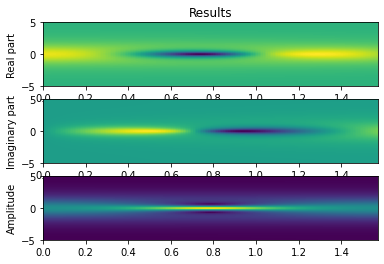

In [9]:
# Make prediction
prediction = model.predict(X_star, operator=None)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

h = np.sqrt(u ** 2 + v ** 2)


# Plot predictions
fig, ax = plt.subplots(3)

ax[0].set_title("Results")
ax[0].set_ylabel("Real part")
ax[0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part")
ax[1].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude")
ax[2].imshow(
    h.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

plt.show()

**Assess the accuracy**

We can employ the test data to assess the accuracy of the trained model.  
Using the normalized $L^2$ norm defined as  
  
Error $u$ = $\frac{1}{||u_{test}||_{L^2}} ||u_{test} - u_{pred}||_{L^2}$  
  
where $u_{test}$ is the reference solution and $u_{pred}$ is the prediction given by the model, we get:  
  
Error $u$: 1.854433e-03  
Error $v$: 2.413796e-03  
Error $h$: 1.426797e-03  
  
We can also plot the absolute value of the error for each point of the domain. It's everywhere in the order E-3.  






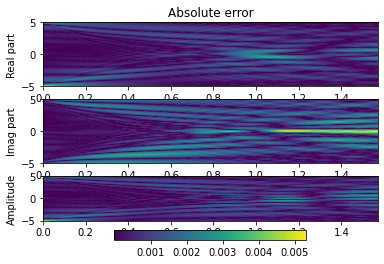